In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import os
from PIL import Image
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from image.models import Image
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet, MIMSAlignment
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import cv2

Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range
Grand Total Image: 14418.44 1121963.5 288906.1
Overall C13_pct: 0.108678564 0.46306208 0.3777947


/var/folders/v5/v1r03h0s3f50cyrz1tz2sfqc0000gn/T/ipykernel_2372/472500170.py:78: RuntimeWarning: invalid value encountered in divide
  c13_pct_img = np.divide(c13_pct_img, total_img, out=np.full_like(c13_pct_img, np.nan))


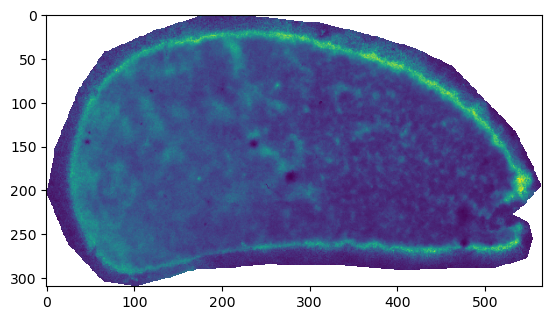

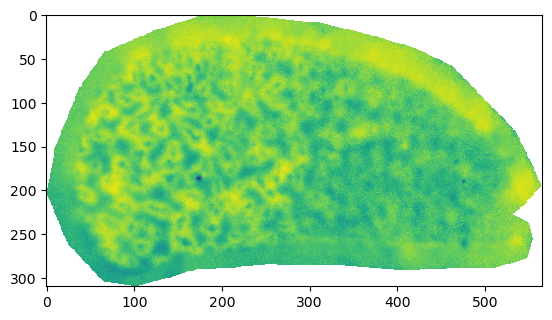

C3 [0, 1, 2] [0.316, 0.293, 0.392]
Polymer C3 % of total: 0.012, Overall 13C pct for polymer: 0.359
C4 [0, 1, 2, 3, 4] [0.212, 0.172, 0.351, 0.194, 0.071]
Polymer C4 % of total: 0.054, Overall 13C pct for polymer: 0.435
C5 [0, 1, 2, 3, 4] [0.176, 0.125, 0.275, 0.294, 0.13]
Polymer C5 % of total: 0.084, Overall 13C pct for polymer: 0.415
C6 [0, 1, 2, 3, 4, 5] [0.165, 0.111, 0.215, 0.253, 0.183, 0.073]
Polymer C6 % of total: 0.119, Overall 13C pct for polymer: 0.400
C7 [0, 1, 2, 3, 4, 5, 6] [0.143, 0.076, 0.144, 0.237, 0.204, 0.153, 0.043]
Polymer C7 % of total: 0.177, Overall 13C pct for polymer: 0.417
C8 [0, 1, 2, 3, 4, 5, 6] [0.148, 0.061, 0.098, 0.206, 0.235, 0.162, 0.09]
Polymer C8 % of total: 0.146, Overall 13C pct for polymer: 0.396
C9 [0, 1, 2, 3, 4, 5, 6] [0.123, 0.053, 0.083, 0.153, 0.203, 0.243, 0.141]
Polymer C9 % of total: 0.122, Overall 13C pct for polymer: 0.395
C10 [0, 1, 2, 3, 4, 5, 6, 7] [0.108, 0.051, 0.055, 0.096, 0.179, 0.224, 0.192, 0.095]
Polymer C10 % of total: 0.

In [4]:
import pathlib
from collections import Counter

from pyometiff import OMETIFFReader


def fpath(mouse):
    # Define the file path and reader setup
    basedir = "/Volumes/Chris_SSD/Glycogen_MALDI-IMS/Glycogen_results_24_08_22/single-dataset"
    suffix = "ratios/glycogen_ratio_list;5.0;raw;TIC;own;off;turbo/glycogen_ratio_list;5.0;raw;TIC;own;off;turbo.ome.tiff"
    folder = {
        "m2": "Glycogen_4h C13_m2__240822_roi=#0",
        "m5": "Glycogen_4h C13_m5_2_240822_roi=#0",
        "m8": "Glycogen_4h C13_m8_240822_roi=#0",
        "ctl": "Glycogen_ctl___240822_roi=#0"
    }[mouse]
    return Path(os.path.join(basedir, folder, suffix))
  
def get_glycogen_data(img_fpath, display=False):
    # Read the OME-TIFF file
    reader = OMETIFFReader(fpath=img_fpath)
    img_array, metadata, xml_metadata = reader.read()


    # Extract the channel data and identify base glucose polymer weights
    all_channels_full = [c for c in metadata['Channels'].keys()]
    all_channels = [c.split()[0] for c in all_channels_full]
    all_channel_weights = [float(c.split()[0].split(' ')[0]) for c in metadata['Channels'].keys() if ' Da' in c]
    channel_counts = Counter(all_channels)
    # Filter channels with multiple appearances and convert them to float
    base_channel_daltons = sorted(list(set([float(c) for c in all_channels if channel_counts[c] > 1])))

    # Define glucose molecule base weight and 13C6 weight increment (approx. 6 daltons)
    glucose_weight = 162
    C13_increment = 6

    # Calculate glucose polymerization levels (C3, C4, etc.) based on weight
    glucose_counts = [(round((weight - 527) / glucose_weight) + 3) for weight in base_channel_daltons]

    # Create the desired data structure
    polymerization_data = {}

    # Loop through each channel, associating with glucose polymerization levels
    for base_weight, glucose_count in zip(base_channel_daltons, glucose_counts):
        key = f"C{glucose_count}"
        polymerization_data[key] = []
        total_img = None
        c13_pct_img = None
        c13_i = 0
        while c13_i <= glucose_count:
            to_add = C13_increment * c13_i
            weight = next((w for w in all_channel_weights if w >= (base_weight + to_add) and w <= base_weight + to_add+1), None)
            if weight:
                channel_key = next((k for k in metadata['Channels'].keys() if f"{weight:.3f} Da" in k), None)
                if channel_key:
                    channel_num = int(metadata['Channels'][channel_key]['ID'].split(':')[-1])
                    img_data = img_array[channel_num, :, :]
                    polymerization_data[key].append({
                        "key": f"13C",
                        "img": img_data,  # Image data for the channel
                        "13C_count": c13_i,  # Number of 13C6 molecules
                    })
                    if total_img is None:
                        total_img = img_data  # If first iteration, set total_img to the current img_data
                    else:
                        total_img = np.add(total_img, img_data)

                    if c13_pct_img is None:
                        c13_pct_img = np.zeros_like(img_data)
                    if glucose_count > 0:
                        c13_pct_img += (c13_i / glucose_count) * img_data
            c13_i += 1
        if total_img is not None:
            polymerization_data[key].append({
                "key": "total",
                "img": total_img  # Summed image data for all c13_i values
            })
            c13_pct_img = np.divide(c13_pct_img, total_img, out=np.full_like(c13_pct_img, np.nan))
            polymerization_data[key].append({
                "key": "13C_pct",
                "img": c13_pct_img  # Add C13 percentage image
            })
            C13_pct_for_polymer = np.nansum([c['img'] * c['13C_count'] for c in polymerization_data[key] if c['key'] == '13C']) / (np.nansum(total_img) * glucose_count)
            polymerization_data[key].append({
                "key": "13C_pct_for_polymer",
                "value": C13_pct_for_polymer  # Avg 13C signal for all glucose molecules
            })

        for i in range(0, glucose_count+1):
            c13_item = next((c for c in polymerization_data[key] if c['key'] == '13C' and c['13C_count']==i), None)
            if c13_item:
                c13_item['polymer_signal_pct'] = round(np.nansum(c13_item['img']) / np.nansum(total_img), 3)
        
    # Initialize variables to accumulate the total and weighted C13_pct
    grand_total_img = None
    grand_total_carbons = None
    grand_total_13C_carbons = None

    # Now, calculate the grand total and weighted C13_pct
    for g_ct, vals in polymerization_data.items():
        # Extract the total image and C13_pct image
        total_img = next((v['img'] for v in vals if v['key'] == 'total'), None)
        c13_pct_img = next((v['img'] for v in vals if v['key'] == '13C_pct'), None)

        # Get the glucose count from the key name (e.g., C3, C4)
        glucose_count = int(g_ct[1:])  # Strip the 'C' and get the number

        # Add the total image to the grand total
        if grand_total_img is None:
            grand_total_img = np.zeros_like(total_img)  # Initialize to zeros
        grand_total_img = np.add(grand_total_img, total_img)

        # Add the weighted C13_pct to the sum
        if grand_total_carbons is None:
            grand_total_carbons = np.zeros_like(total_img)
        grand_total_carbons = np.add(grand_total_carbons, total_img * glucose_count)

        if grand_total_13C_carbons is None:
            grand_total_13C_carbons = np.zeros_like(total_img)
        img_13c_carbons = np.multiply(total_img, c13_pct_img) * glucose_count
        img_13c_carbons[np.isnan(total_img) | np.isnan(c13_pct_img)] = 0
        grand_total_13C_carbons = np.add(grand_total_13C_carbons, img_13c_carbons)

    for g_ct, vals in polymerization_data.items():
        val_total = next((t for t in vals if t['key'] == 'total'))['img']
        vals.append({"key": 'polymer_pct_of_total', "value": np.nansum(val_total) / np.nansum(grand_total_img)})
    overall_c13_pct = grand_total_13C_carbons / grand_total_carbons

    # Add the grand total and overall C13_pct to polymerization_data at the base level
    polymerization_data['total'] = grand_total_img
    polymerization_data['C13_pct'] = overall_c13_pct

    if display:
        # Print results
        print("Grand Total Image:", np.nanmin(grand_total_carbons), np.nanmax(grand_total_carbons), np.nanmean(grand_total_carbons))
        print("Overall C13_pct:", np.nanmin(overall_c13_pct), np.nanmax(overall_c13_pct), np.nanmean(overall_c13_pct))
        plt.imshow(grand_total_img)
        plt.show()
        plt.imshow(overall_c13_pct)
        plt.show()
        for (g_ct, vals) in polymerization_data.items():
            c13_pct_items = [v for v in vals if 'key' in v and v['key'] == '13C']
            c13_keys = [v['13C_count'] for v in c13_pct_items]
            c13_pcts = [v['polymer_signal_pct'] for v in c13_pct_items]
            if c13_pcts:
                polymer_pct_of_total = next((c['value'] for c in vals if c['key'] == 'polymer_pct_of_total'))
                c13_avg_for_polymer = next((c['value'] for c in vals if c['key'] == "13C_pct_for_polymer"))
                
                # Use string formatting to properly round and display
                print(g_ct, c13_keys, c13_pcts)
                print(f"Polymer {g_ct} % of total: {polymer_pct_of_total:.3f}, Overall 13C pct for polymer: {c13_avg_for_polymer:.3f}")
    return polymerization_data

# m2, m5, m8, or ctl
result = get_glycogen_data(fpath("m8"), display=True)



Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range
Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range


/var/folders/v5/v1r03h0s3f50cyrz1tz2sfqc0000gn/T/ipykernel_2372/52059305.py:78: RuntimeWarning: invalid value encountered in divide
  c13_pct_img = np.divide(c13_pct_img, total_img, out=np.full_like(c13_pct_img, np.nan))


Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range
Key not found: list index out of range
Key not found: list index out of range
key not found list index out of range
Key not found: list index out of range


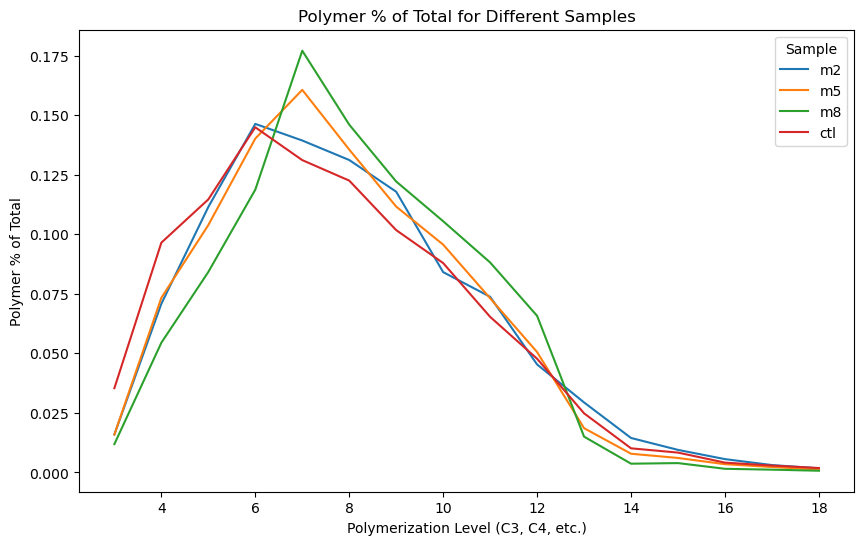

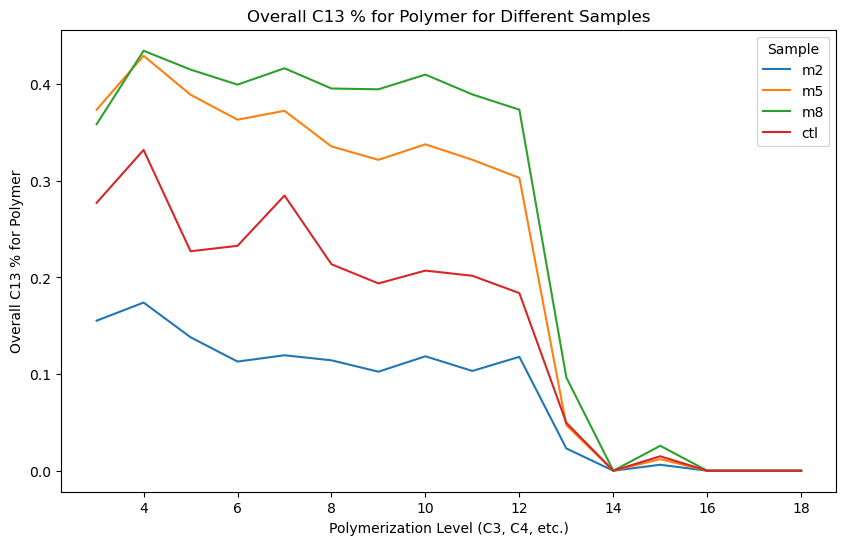

In [3]:
import matplotlib.pyplot as plt

def plot_glycogen_data():
    samples = ['m2', 'm5', 'm8', 'ctl']
    polymerization_data_by_sample = {}
    
    # Collect data for each sample
    for sample in samples:
        polymerization_data_by_sample[sample] = get_glycogen_data(fpath(sample))

    # Collect polymerization levels (keys that start with 'C' and are followed by an integer)
    polymerization_levels = sorted(set(
        [int(g_ct[1:]) for g_ct in polymerization_data_by_sample['m2'].keys() if g_ct.startswith('C') and g_ct[1:].isdigit()]
    ))

    # Initialize data for plotting
    polymer_pct_total = {sample: [] for sample in samples}
    c13_pct_polymer = {sample: [] for sample in samples}

    # Collect data for each polymerization level and sample
    for sample in samples:
        for g_ct in polymerization_levels:
            g_key = f"C{g_ct}"
            polymer_pct_total[sample].append(
                next((c['value'] for c in polymerization_data_by_sample[sample][g_key] if c['key'] == 'polymer_pct_of_total'), None)
            )
            c13_pct_polymer[sample].append(
                next((c['value'] for c in polymerization_data_by_sample[sample][g_key] if c['key'] == '13C_pct_for_polymer'), None)
            )

    # Plot Polymer % of Total
    plt.figure(figsize=(10, 6))
    for sample in samples:
        plt.plot(polymerization_levels, polymer_pct_total[sample], label=sample)
    plt.xlabel('Polymerization Level (C3, C4, etc.)')
    plt.ylabel('Polymer % of Total')
    plt.title('Polymer % of Total for Different Samples')
    plt.legend(title="Sample")
    plt.show()

    # Plot Overall C13 % for Polymer
    plt.figure(figsize=(10, 6))
    for sample in samples:
        plt.plot(polymerization_levels, c13_pct_polymer[sample], label=sample)
    plt.xlabel('Polymerization Level (C3, C4, etc.)')
    plt.ylabel('Overall C13 % for Polymer')
    plt.title('Overall C13 % for Polymer for Different Samples')
    plt.legend(title="Sample")
    plt.show()

# Call the function to generate the plots
plot_glycogen_data()
